# **Best model calibration**

Before beginning, we will import all the required libraries and modules.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    cross_val_predict, 
    StratifiedGroupKFold
)
from sklearn.calibration import (
    CalibrationDisplay, 
    CalibratedClassifierCV
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    confusion_matrix, 
    matthews_corrcoef, 
    precision_score, 
    recall_score,
    accuracy_score, 
    make_scorer, 
    average_precision_score, 
    brier_score_loss,
    balanced_accuracy_score
)
from imblearn.metrics import specificity_score
from sklearn.semi_supervised import LabelSpreading

We will load a preprocessed dataset and an optimized model with a defined threshold.

In [11]:
df = pd.read_csv('/home/yangxin/Desktop/script_rdrp/dataset/rdrp_03_bioactivity_data_curated.csv')
x = df.drop(columns=['molecule_chembl_id',"class","pchembl_value","mw","logP","mol"])
y = df["class"]
groups_int = pd.read_csv('/home/yangxin/Desktop/script_rdrp/dataset/groups_int')['index'].tolist() # groups of scaffolds, so we can prevent the same scaffold from appearing in both the training and testing sets.
model = pickle.load(open('/home/yangxin/Desktop/script_rdrp/dataset/LabelSpreading_rdrp_sarscov2_model_trained.pkl', 'rb'))


/tmp/ipykernel_120718/4120234636.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/yangxin/Desktop/script_rdrp/dataset/rdrp_03_bioactivity_data_curated.csv')


In [12]:
#First we will remove low variance features because these features do not provide much useful information for the model 
# using Bernoulli distribution which it's useful when we work with binary data.
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
x = selection.fit_transform(x)
x.shape

sgk = StratifiedGroupKFold(n_splits=5)
sgk.get_n_splits(x, y)

for train_idx, test_idx in sgk.split(x, y, groups_int):
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [13]:
model.fit(x,y)
probabilities = model.predict_proba(x_test)[:, 0]
prediction = model.predict(x_test)

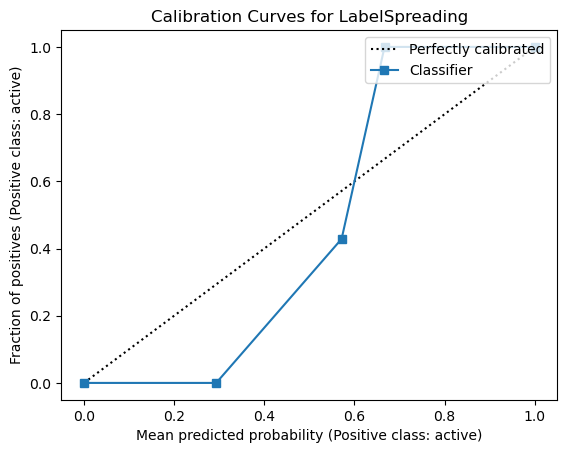

In [14]:
#calibration curve evaluates how well the predicted probabilities of a classification model match the actual probabilities
disp = CalibrationDisplay.from_predictions(y_test, probabilities, pos_label="active")
plt.title("Calibration Curves for LabelSpreading")
plt.legend(loc="upper right")
plt.show()

We compare the calibrated predictions with the non-calibrated ones using the Brier score loss, which measures the mean squared difference between the predicted probabilities and the actual outcomes—lower values indicate better performance. Additionally, we use balanced accuracy as a substitute for the R² score in classification models

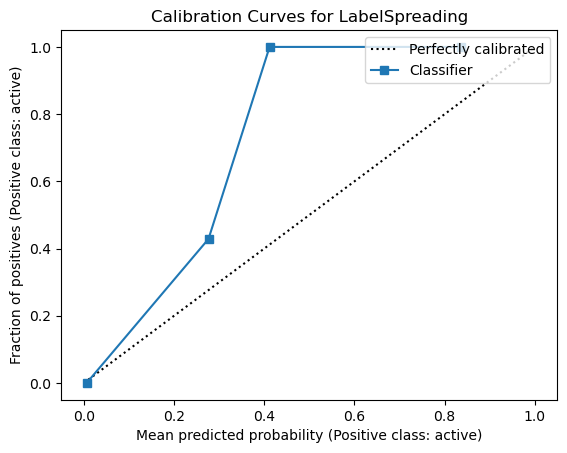

In [15]:
calibrated_rf = CalibratedClassifierCV(LabelSpreading(), method = 'sigmoid', cv= 5)
calibrated_rf.fit(x, y)

prediction_calibrated = calibrated_rf.predict(x_test)
probabilities_calibrated = calibrated_rf.predict_proba(x_test)[:, 0]

disp_calibrated = CalibrationDisplay.from_predictions(y_test, probabilities_calibrated, pos_label="active")

plt.title("Calibration Curves for LabelSpreading")
plt.legend(loc="upper right")
plt.show()

In [16]:
score_loss_no_calibrated = brier_score_loss(y_test, probabilities, pos_label="active")
balanced_accuracy_no_calibrated = balanced_accuracy_score(y_test, prediction)

score_loss_calibrated = brier_score_loss(y_test, probabilities_calibrated, pos_label="active")
balanced_accuracy_calibrated = balanced_accuracy_score(y_test, prediction_calibrated)

print(f'Brier score loss no calibrated: {score_loss_no_calibrated}, Accuracy no calibrated: {balanced_accuracy_no_calibrated}')
print(f'Brier score loss calibrated: {score_loss_calibrated}, Accuracy calibrated: {balanced_accuracy_calibrated}')

Brier score loss no calibrated: 0.002664155422753562, Accuracy no calibrated: 0.9988518943742825
Brier score loss calibrated: 0.003171625115696282, Accuracy calibrated: 0.8214285714285714


We observe that the model performs better without calibration, so we will proceed without it. Next, we will optimize the model's threshold to minimize false positives, as this is the primary focus of the study. To achieve this, we will sort the values by precision to select a threshold with fewer false positives, and by Matthews correlation to ensure the overall quality of the binary model

In [17]:
thresholds = np.arange(0, 1, 0.01)
specificity_scorer = make_scorer(specificity_score, average='weighted')

balanced_accuracy_threshold = []
matthews_corrcoef_threshold = []
precision_threshold = []
specificity_threshold = []
recall_threshold = []

for thres in thresholds:
    y_pred = np.where(probabilities > thres, "active", "inactive")
    balanced_accuracy_threshold.append(balanced_accuracy_score(y_test, y_pred))
    matthews_corrcoef_threshold.append(matthews_corrcoef(y_test, y_pred))
    precision_threshold.append(precision_score(y_test, y_pred, pos_label="active"))
    specificity_threshold.append(specificity_score(y_test, y_pred, pos_label="active"))
    recall_threshold.append(recall_score(y_test, y_pred, pos_label="active"))

metrics_threshold_nc = pd.DataFrame({'thresholds': thresholds, 'accuracy': balanced_accuracy_threshold, 'matthews_corrcoef': matthews_corrcoef_threshold,
                                  'precision': precision_threshold, 'specificity': specificity_threshold,
                                  'recall': recall_threshold})

metrics_threshold_nc.sort_values(by= ['precision','matthews_corrcoef'], ascending=False, inplace=True)
metrics_threshold_nc = metrics_threshold_nc[["thresholds", "matthews_corrcoef", "accuracy", "specificity", "precision", "recall"]]
metrics_threshold_nc.reset_index(drop=True, inplace=True)

metrics_threshold_nc.head()

,thresholds,matthews_corrcoef,accuracy,specificity,precision,recall
0,0.60,0.884883,0.892857,1.0,1.0,0.785714
1,0.61,0.884883,0.892857,1.0,1.0,0.785714
2,0.62,0.884883,0.892857,1.0,1.0,0.785714
3,0.63,0.884883,0.892857,1.0,1.0,0.785714
4,0.64,0.884883,0.892857,1.0,1.0,0.785714


As we can observe, starting from 0.60, the precision value improves significantly, approaching 1, and the Matthews correlation coefficient also shows a considerable result. Therefore, the optimal threshold for our purpose will be 0.6.

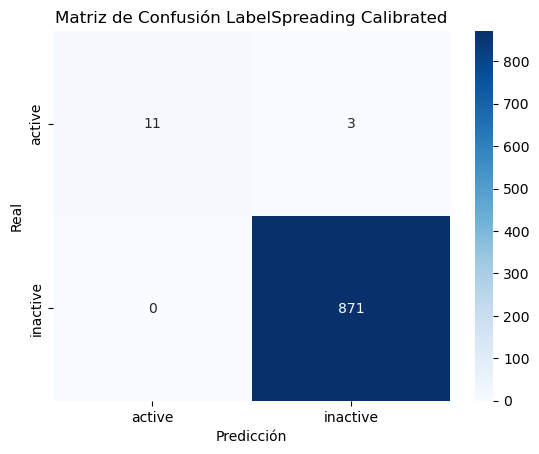

In [19]:
thres = metrics_threshold_nc.thresholds[0]
y_pred_final = np.where(probabilities > thres, "active", "inactive")

cm_1_calibrated = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm_1_calibrated, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión LabelSpreading Calibrated')
plt.show()

# **Saving a Machine Learning Model with an Optimized Decision Threshold**

In [30]:
thres = metrics_threshold_nc.thresholds[10]

with open('optimized_model.pkl', 'wb') as f:
    pickle.dump({'model': model, 'threshold': thres}, f)